In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import EnsembleKalmanFilter, EnsembleKalmanFilter_All
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

float64


Initialisation of a twin experiment. 

In [2]:
signal_params = ConfigDict(KDV_params_2_SALT)
ensemble_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_params.update(E=128,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')

Now we specify the models, by calling the class.

In [3]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)


In [9]:
observation_spatial_frequency = 4
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.01
number_of_observations_time = 32
observation_temporal_frequency = int(ensemble_model.params.nt/number_of_observations_time)


enkf = EnsembleKalmanFilter_All(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    observation_locations = observation_locations,
)

In [10]:
da_steps = number_of_observations_time
key_0 = jax.random.PRNGKey(0)
final, all = enkf.run(initial_ensemble, initial_signal,da_steps,key_0) #the final input is scan length? 

In [11]:
print("Final state shape:", all[0].shape,all[1].shape,all[2].shape)
print('nt:', ensemble_model.params.nt,32*125)

particles = jnp.concatenate(all[0], axis=0)
print("Particles shape:", particles.shape)
signal = jnp.concatenate(all[1], axis=0)
observations = all[2]
print("Observations shape:", observations.shape)


Final state shape: (32, 125, 128, 256) (32, 125, 1, 256) (32, 1, 256)
nt: 4000 4000
Particles shape: (4000, 128, 256)
Observations shape: (32, 1, 256)


In [ ]:
time_step = ensemble_model.params.nt    
print("Time step shape:", time_step)
def interactive_plot(time_step):
    plt.figure(figsize=(10, 5))
    plt.plot(signal_model.x, signal[time_step, 0, :], color='k', label='signal')
    plt.plot(signal_model.x, particles[time_step, :, :].T, color='b', alpha=0.3, linewidth=0.5, label='particles')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title(f'Signal and Particles at time Step {time_step}')
    plt.legend(['signal', 'particles'])
    plt.show()

interact(interactive_plot, time_step=(0, time_step - 1))

Time step shape: 4000


interactive(children=(IntSlider(value=1999, description='time_step', max=3999), Output()), _dom_classes=('widg…

<function __main__.interactive_plot(time_step)>

Put in the initial condition.

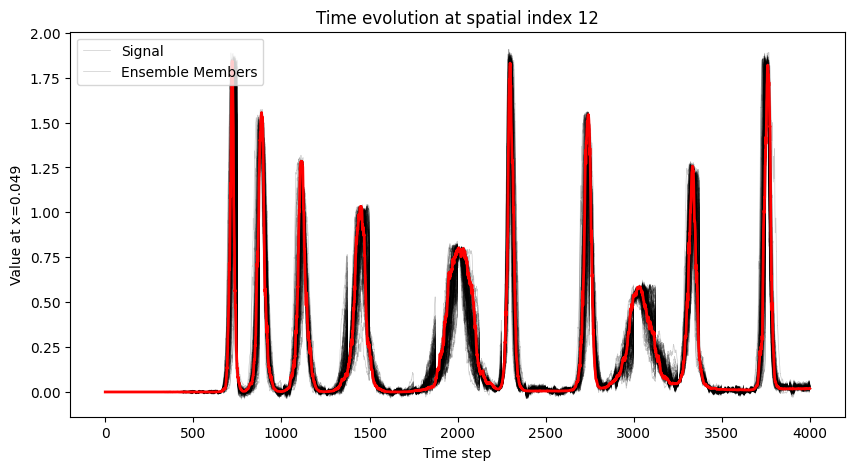

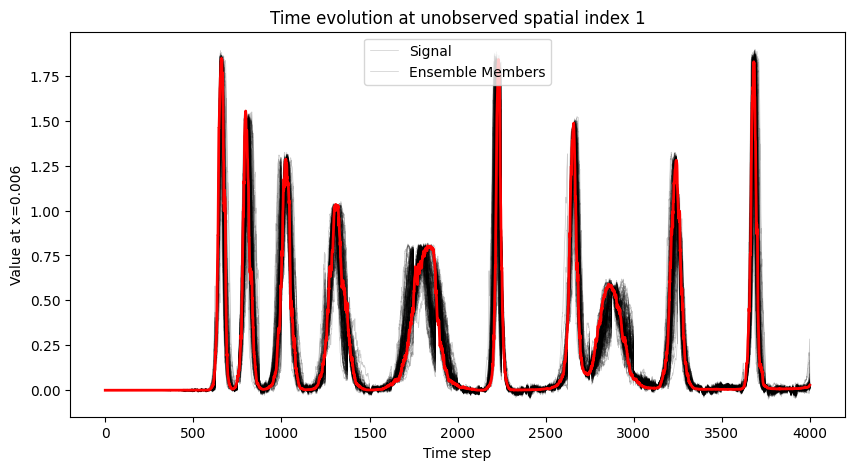

In [13]:
# Choose a spatial index to track (e.g., the first observation location)
spatial_idx = observation_locations[3]

plt.figure(figsize=(10, 5))
plt.plot(particles[:, :, spatial_idx], color='k', alpha=0.2, linewidth=0.5)

plt.plot(signal[:, 0, spatial_idx], label='Signal', color='r', linewidth=2)
plt.xlabel('Time step')
plt.ylabel(f'Value at x={signal_model.x[spatial_idx]:.3f}')
plt.title(f'Time evolution at spatial index {spatial_idx}')
plt.legend(['Signal', 'Ensemble Members'])
plt.show()

# Choose a spatial index where there is no observation (not in observation_locations)
all_indices = set(range(signal_model.x.shape[0]))
unobserved_indices = list(all_indices - set(observation_locations))
spatial_idx_no_data = unobserved_indices[0]  # pick the first unobserved index

plt.figure(figsize=(10, 5))
plt.plot(particles[:, :, spatial_idx_no_data], color='k', alpha=0.2, linewidth=0.5)
plt.plot(signal[:, 0, spatial_idx_no_data], label='Signal', color='r', linewidth=2)
plt.xlabel('Time step')
plt.ylabel(f'Value at x={signal_model.x[spatial_idx_no_data]:.3f}')
plt.title(f'Time evolution at unobserved spatial index {spatial_idx_no_data}')
plt.legend(['Signal', 'Ensemble Members'])
plt.show()